In [ ]:
%pip install ipympl
#%matplotlib inline
#%matplotlib widget

Environment Setup+angle conversion

In [2]:
# =========================================================
# Cell 1 — MonsterTruck environment setup (MuJoCo, radians)
# Utilities, constants, and policies ONLY (no collection here)
# =========================================================
import os, math, time
import numpy as np
import mujoco

# ------------------- Global config -------------------
SEED = 0
rng = np.random.default_rng(SEED)

XML_PATH   = "monstertruck.xml"   # update if needed
FRAME_SKIP = 10                   # sim steps per control
ACTION_LOW, ACTION_HIGH = -1.0, 1.0

# Sign convention: + when pitching toward the head direction
PITCH_SIGN = +1   # flip to -1 if your model's "forward" comes out negative

# Success hysteresis (now in radians)
SUCCESS_ENTER_RAD    = np.deg2rad(178.0)
SUCCESS_RELEASE_RAD  = np.deg2rad(176.5)
MAX_UPRIGHT_RATE_RAD = np.deg2rad(60.0)
HOLD_NEEDED          = 1

# ------------------- Angle helpers (radians) -------------------
def clip(v, lo, hi):
    return lo if v < lo else (hi if v > hi else v)

def angdiff_rad(curr, prev):
    """Minimal signed angle diff in radians, (-pi, pi]."""
    return ((curr - prev + np.pi) % (2.0 * np.pi)) - np.pi

def get_signed_flip_rad(data, body_id, roof_is_neg_z=True):
    """
    Signed flip angle φ [rad] with your convention:
      0 = upside-down, ±π = upright.
      Positive when pitching toward the head (forward), negative otherwise.

    Numerically-stable via atan2(||z×r||, z·r). Sign from (z×r)·y (about pitch axis).
    """
    R = data.xmat[body_id].reshape(3, 3)     # body->world rotation
    z_w = np.array([0.0, 0.0, 1.0], float)   # world up

    body_z_world = R[:, 2]
    r_w = -body_z_world if roof_is_neg_z else body_z_world  # roof normal in world
    y_w =  R[:, 1]  # body Y (pitch axis) expressed in world

    v = np.cross(z_w, r_w)                   # perpendicular to both
    c = float(np.dot(z_w, r_w))              # cos-like term
    s_axis = float(np.dot(v, y_w))           # sign wrt pitch axis (forward/backward)
    theta = math.atan2(np.linalg.norm(v), clip(c, -1.0, 1.0))  # [0, π] in radians

    # Persistent sign memory to avoid flicker near 0
    if not hasattr(get_signed_flip_rad, "_flip_sign"):
        get_signed_flip_rad._flip_sign = 0.0
    if theta > np.deg2rad(0.5) and abs(s_axis) > 1e-12:
        get_signed_flip_rad._flip_sign = 1.0 if (PITCH_SIGN * s_axis) > 0.0 else -1.0

    sgn = get_signed_flip_rad._flip_sign if get_signed_flip_rad._flip_sign != 0.0 else 1.0
    return sgn * theta

# ------------------- Reset / control helpers -------------------
def reset_state(model, data):
    """Upside-down spawn with tiny jitter."""
    mujoco.mj_resetData(model, data)
    data.qpos[:3] = np.array([0.0, 0.0, 0.2])  # slight above ground
    data.qvel[:]  = 0.0
    data.qpos[3:7] = np.array([0.0, 1.0, 0.0, 0.0])  # 180° about X (upside-down)
    mujoco.mj_forward(model, data)
    # reset flip-sign memory
    get_signed_flip_rad._flip_sign = 0.0

def find_throttle_ids(model):
    ids = []
    for name in ["front_left_motor", "front_right_motor",
                 "rear_left_motor", "rear_right_motor"]:
        aid = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, name)
        if aid != -1:
            ids.append(aid)
    if not ids:
        ids = list(range(model.nu))  # fallback: drive all actuators
    return ids

def apply_throttle(data, ids, u):
    if data.ctrl is not None and data.ctrl.size > 0:
        data.ctrl[:] = 0.0
        for aid in ids:
            data.ctrl[aid] = u

# ------------------- Continuous policies (use radians) -------------------
def random_policy():
    return float(rng.uniform(ACTION_LOW, ACTION_HIGH))

def swing_cont_policy(phi_rad, omega_rad, k=0.7, bias=0.0, noise_std=0.15):
    """
    Continuous 'swing' throttle (radians):
      - scales with angular rate via tanh(·)
      - optional small Gaussian exploration
    Returns: float in [-1, 1]
    """
    base = k * np.tanh(omega_rad / 3.0) + bias * np.sign(omega_rad)
    a = base + noise_std * rng.normal()
    return float(np.clip(a, ACTION_LOW, ACTION_HIGH))

# =========================================================
# Flip angle utilities for training (centralized here)
# =========================================================
class FlipTracker:
    """
    Per-env tracker that returns:
      - phi_rad          : upside-down–centered pitch in [-pi, pi]
      - omega_rad_s      : wrapped rate dphi/dt (rad/s)
      - phi_unwrapped_rad: continuous accumulated angle (no wrapping)
    Uses get_signed_flip_rad(...) to keep the definition consistent everywhere.
    """
    def __init__(self, dt_ctrl, roof_is_neg_z=True):
        self.dt = float(dt_ctrl) if dt_ctrl > 0 else 1e-6
        self.roof_is_neg_z = bool(roof_is_neg_z)
        self.prev_phi = None
        self.unwrapped = 0.0

    def reset(self):
        self.prev_phi = None
        self.unwrapped = 0.0
        # also reset the global sign-memory used by get_signed_flip_rad
        get_signed_flip_rad._flip_sign = 0.0

    def step(self, data, body_id):
        """Call after advancing physics for one control interval."""
        phi = get_signed_flip_rad(data, body_id, roof_is_neg_z=self.roof_is_neg_z)
        if self.prev_phi is None:
            dphi = 0.0
        else:
            dphi = angdiff_rad(phi, self.prev_phi)   # minimal signed diff ∈ (-pi, pi]
        omega = dphi / self.dt
        self.unwrapped += dphi
        self.prev_phi = phi
        return float(phi), float(omega), float(self.unwrapped)

def ud_pitch_deg_from_phi(phi_rad):
    """Convert φ to degrees in [-180, 180], where 0°=upside-down, ±180°=upright."""
    deg = ((math.degrees(float(phi_rad)) + 180.0) % 360.0) - 180.0
    return float(deg)

def get_ud_pitch_deg(data, body_id, roof_is_neg_z=True):
    """Direct degrees readout from MuJoCo state using your φ definition."""
    return ud_pitch_deg_from_phi(get_signed_flip_rad(data, body_id, roof_is_neg_z=roof_is_neg_z))

def make_flip_tracker(model, frame_skip=FRAME_SKIP):
    """Factory using env control interval dt_ctrl = model.opt.timestep * FRAME_SKIP."""
    return FlipTracker(dt_ctrl=model.opt.timestep * frame_skip, roof_is_neg_z=True)


Tester for environment setup

In [ ]:
# =========================================================
# Cell 2 — Debug viewer: UD pitch (degrees) only
# Keys: W=+throttle, S=−throttle, SPACE=0, ESC=quit
# =========================================================
import os, time, math
import numpy as np
import mujoco
from mujoco.glfw import glfw

# --- Load model, data, and set initial state using Cell 1 helpers ---
if not os.path.exists(XML_PATH):
    raise FileNotFoundError(f"Cannot find XML_PATH: {XML_PATH}")
model = mujoco.MjModel.from_xml_path(XML_PATH)
data  = mujoco.MjData(model)
reset_state(model, data)

# Body / actuators
chassis_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
if chassis_id == -1:
    chassis_id = 0
throttle_ids = find_throttle_ids(model)
print(f"Driving actuators: {[mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_ACTUATOR, i) for i in throttle_ids]}")
print(f"Initial chassis COM z: {data.xpos[chassis_id,2]:.3f} m")

# --- Viewer setup ---
if not glfw.init():
    raise RuntimeError("GLFW init failed")
window = glfw.create_window(1000, 800, "MonsterTruck — UD Pitch (degrees)", None, None)
if not window:
    glfw.terminate()
    raise RuntimeError("GLFW window creation failed")
glfw.make_context_current(window)
glfw.swap_interval(1)  # vsync

cam = mujoco.MjvCamera()
opt = mujoco.MjvOption()
scene = mujoco.MjvScene(model, maxgeom=10000)
context = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150)
cam.distance, cam.elevation, cam.azimuth = 3.0, -25, 90

# --- Keyboard throttle (manual) ---
throttle = 0.0
def key_callback(window, key, scancode, action, mods):
    global throttle
    if action in (glfw.PRESS, glfw.REPEAT):
        if key == glfw.KEY_W:       throttle = +1.0
        elif key == glfw.KEY_S:     throttle = -1.0
        elif key == glfw.KEY_SPACE: throttle = 0.0
    elif action == glfw.RELEASE and key in (glfw.KEY_W, glfw.KEY_S):
        throttle = 0.0
glfw.set_key_callback(window, key_callback)

# --- Timing ---
dt_ctrl = model.opt.timestep * FRAME_SKIP
last_print = time.perf_counter()
sim_start_wall = last_print
REALTIME = True

print("Controls: W=+throttle | S=−throttle | SPACE=0 | ESC=quit")
print("Readout: UD-pitch (deg) where 0°=upside-down, ±180°=upright (from Cell 1 conversion).")

while not glfw.window_should_close(window):
    if glfw.get_key(window, glfw.KEY_ESCAPE) == glfw.PRESS:
        break

    # Apply same throttle to all selected actuators
    apply_throttle(data, throttle_ids, throttle)

    # Step physics faster than render
    for _ in range(FRAME_SKIP):
        mujoco.mj_step(model, data)

    # Real-time pacing
    if REALTIME:
        target_wall = sim_start_wall + data.time
        now = time.perf_counter()
        if now < target_wall:
            time.sleep(target_wall - now)

    # Follow camera
    cam.lookat[:] = data.xpos[chassis_id]

    # Render
    w, h = glfw.get_framebuffer_size(window)
    if w > 0 and h > 0:
        mujoco.mjv_updateScene(model, data, opt, None, cam, mujoco.mjtCatBit.mjCAT_ALL, scene)
        viewport = mujoco.MjrRect(0, 0, w, h)
        mujoco.mjr_render(viewport, scene, context)
    glfw.swap_buffers(window)
    glfw.poll_events()

    # --- Read UD pitch in degrees using Cell 1 conversion only ---
    # (No extra angle math here.)
    phi_rad = get_signed_flip_rad(data, chassis_id, roof_is_neg_z=True)
    ud_pitch_deg = ud_pitch_deg_from_phi(phi_rad)  # [-180, 180], 0=UD, ±180=UPRIGHT

    # Console readout (~4 Hz)
    now = time.perf_counter()
    if now - last_print > 0.25:
        speed_ratio = data.time / (now - sim_start_wall + 1e-12)
        pos = data.xpos[chassis_id]
        print(f"t={data.time:6.2f}s  pos=({pos[0]:+.2f},{pos[1]:+.2f},{pos[2]:+.2f})  "
              f"UD-pitch={ud_pitch_deg:+7.2f}°  thr={throttle:+.2f}  ×{speed_ratio:.2f}")
        last_print = now

glfw.terminate()
print("Debug viewer terminated.")


Data Collection for GP

In [3]:
# =========================================================
# Cell 3 — Initial data collection for GP (random / Sobol)
# - Collect transitions: (phi, omega, u) -> (dphi, domega)
# - Moderate amount of data, good local coverage near UD
# =========================================================


# Optional: Sobol sequence for nicer action coverage
try:
    from scipy.stats import qmc
    _has_scipy = True
except ImportError:
    _has_scipy = False
    print("[Cell 3] SciPy not found — falling back to uniform random actions.")

# ---------- Config ----------
TOTAL_CTRL_STEPS = 50000     # number of control steps => samples
EPISODE_LEN_MAX  = 2000       # max control steps per episode before reset

# Clip angular velocity for GP inputs
OMEGA_CLIP_DEG   = 240.0
OMEGA_CLIP_RAD   = np.deg2rad(OMEGA_CLIP_DEG)

# Action pulse / priming
HOLD_CTRL_STEPS  = 6         # hold each sampled action this many control steps
PRIME_CTRL_STEPS = 20        # strong priming steps after each reset
PRIME_AMPL       = 0.9       # priming throttle amplitude

# Kick at reset to break symmetry and get some swing
KICK_ANGVEL_DEG  = 150.0     # magnitude of angular velocity kick (deg/s)
KICK_STEPS       = 40        # physics steps to let the kick take effect

PRINT_EVERY      = 1_000     # progress print interval


# ---------- Load model & data ----------
if not os.path.exists(XML_PATH):
    raise FileNotFoundError(f"[Cell 3] Cannot find XML_PATH: {XML_PATH}")
model = mujoco.MjModel.from_xml_path(XML_PATH)
data  = mujoco.MjData(model)

# Control timing + angle tracker
dt_ctrl      = model.opt.timestep * FRAME_SKIP
flip_tracker = make_flip_tracker(model, frame_skip=FRAME_SKIP)

# Body / actuators
chassis_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
if chassis_id == -1:
    chassis_id = 0
throttle_ids = find_throttle_ids(model)
print(f"[Cell 3] Driving actuators: {[mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_ACTUATOR, i) for i in throttle_ids]}")
print(f"[Cell 3] FRAME_SKIP={FRAME_SKIP}, dt_ctrl={dt_ctrl:.4f}s")
print(f"[Cell 3] Collecting {TOTAL_CTRL_STEPS} samples (~transitions).")


# ---------- Action sampler (Sobol or uniform) ----------
if _has_scipy:
    sobol = qmc.Sobol(d=1, scramble=True, seed=SEED)

    def sample_throttle():
        """Sobol sample in [-1, 1]."""
        u01 = sobol.random(1)[0, 0]   # in [0,1)
        return float(ACTION_LOW + (ACTION_HIGH - ACTION_LOW) * u01)
else:
    def sample_throttle():
        """Uniform random sample in [-1, 1]."""
        return float(rng.uniform(ACTION_LOW, ACTION_HIGH))


# ---------- Reset with angular-velocity kick ----------
def hard_reset_with_kick():
    """Reset to upside-down, then add a random pitch-rate kick and let it evolve."""
    reset_state(model, data)
    flip_tracker.reset()

    # Kick around Y (pitch axis) with random sign
    kick_sign = np.sign(rng.uniform(-1.0, 1.0)) or 1.0
    kick_rad  = np.deg2rad(KICK_ANGVEL_DEG) * kick_sign

    data.qvel[:] = 0.0
    # Assume root has 6-DoF: qvel[3:6] ~ (wx, wy, wz)
    if data.qvel.size >= 5:
        data.qvel[4] = kick_rad  # world Y angular velocity (approx pitch rate)
    mujoco.mj_forward(model, data)

    # Let the kick evolve for a short while with zero throttle
    apply_throttle(data, throttle_ids, 0.0)
    for _ in range(KICK_STEPS):
        mujoco.mj_step(model, data)

    # Sync the tracker after the kick
    flip_tracker.reset()
    phi0, omega0, _ = flip_tracker.step(data, chassis_id)
    return phi0, omega0


# ---------- Storage for GP training ----------
phi_list      = []   # current φ (rad)
omega_list    = []   # current ω (rad/s, clipped)
u_list        = []   # throttle u
dphi_list     = []   # Δφ over one control step (rad)
domega_list   = []   # Δω over one control step (rad/s)

# Track throttle range
u_min = +np.inf
u_max = -np.inf

# ---------- Main collection loop ----------
phi_prev, omega_prev = hard_reset_with_kick()

prime_steps_left = PRIME_CTRL_STEPS
prime_sign       = np.sign(rng.uniform(-1.0, 1.0)) or 1.0
hold_steps_left  = 0
u_curr           = PRIME_AMPL * prime_sign

steps_done   = 0
episode_step = 0
start_wall   = time.perf_counter()

print("[Cell 3] Starting initial data collection...")
while steps_done < TOTAL_CTRL_STEPS:
    # Episode reset if too long
    if episode_step >= EPISODE_LEN_MAX:
        phi_prev, omega_prev = hard_reset_with_kick()
        prime_steps_left = PRIME_CTRL_STEPS
        prime_sign       = np.sign(rng.uniform(-1.0, 1.0)) or 1.0
        hold_steps_left  = 0
        u_curr           = PRIME_AMPL * prime_sign
        episode_step     = 0

    # ----- Decide action (priming then Sobol pulses) -----
    if prime_steps_left > 0:
        u_curr = PRIME_AMPL * prime_sign
        prime_steps_left -= 1
    else:
        if hold_steps_left <= 0:
            u_curr = sample_throttle()
            hold_steps_left = HOLD_CTRL_STEPS
        hold_steps_left -= 1

    # Track throttle range
    u_min = min(u_min, u_curr)
    u_max = max(u_max, u_curr)

    # ----- Apply action and step physics for one control interval -----
    apply_throttle(data, throttle_ids, u_curr)
    for _ in range(FRAME_SKIP):
        mujoco.mj_step(model, data)

    # Read new state
    phi_curr, omega_curr, _ = flip_tracker.step(data, chassis_id)

    # Compute Δφ (wrapped) and Δω
    dphi   = angdiff_rad(phi_curr, phi_prev)
    domega = omega_curr - omega_prev

    # Clip ω input for GP stability (but deltas are raw)
    omega_clipped = float(np.clip(omega_prev, -OMEGA_CLIP_RAD, OMEGA_CLIP_RAD))

    # ----- Store transition: (prev state, current action) -> deltas -----
    phi_list.append(float(phi_prev))
    omega_list.append(omega_clipped)
    u_list.append(float(u_curr))
    dphi_list.append(float(dphi))
    domega_list.append(float(domega))

    # Prepare for next step
    phi_prev, omega_prev = phi_curr, omega_curr
    steps_done   += 1
    episode_step += 1

    # Periodic progress print
    if steps_done % PRINT_EVERY == 0 or steps_done == TOTAL_CTRL_STEPS:
        elapsed = time.perf_counter() - start_wall
        phi_deg_arr   = np.rad2deg(np.asarray(phi_list,   dtype=np.float32))
        omega_deg_arr = np.rad2deg(np.asarray(omega_list, dtype=np.float32))
        print(
            f"[Cell 3] steps={steps_done}/{TOTAL_CTRL_STEPS}  |  "
            f"φ range (deg) ≈ [{phi_deg_arr.min():+.1f}, {phi_deg_arr.max():+.1f}]  |  "
            f"ω range (deg/s, clipped) ≈ [{omega_deg_arr.min():+.1f}, {omega_deg_arr.max():+.1f}]  |  "
            f"u_range=[{u_min:+.2f}, {u_max:+.2f}]  |  elapsed={elapsed:.1f}s"
        )

print("[Cell 3] Finished initial collection.")


# ---------- Pack into arrays ----------
phi_arr    = np.asarray(phi_list,    dtype=np.float32)
omega_arr  = np.asarray(omega_list,  dtype=np.float32)
u_arr      = np.asarray(u_list,      dtype=np.float32)
dphi_arr   = np.asarray(dphi_list,   dtype=np.float32)
domega_arr = np.asarray(domega_list, dtype=np.float32)

X = np.stack([phi_arr, omega_arr, u_arr], axis=1)   # (N, 3)
Y = np.stack([dphi_arr, domega_arr], axis=1)        # (N, 2)

print(f"[Cell 3] Done. X shape = {X.shape}, Y shape = {Y.shape}")
print(f"[Cell 3] Final φ range (deg) ≈ [{np.rad2deg(phi_arr).min():+.1f}, {np.rad2deg(phi_arr).max():+.1f}]")
print(f"[Cell 3] Final ω range (deg/s, clipped) ≈ [{np.rad2deg(omega_arr).min():+.1f}, {np.rad2deg(omega_arr).max():+.1f}]")
print(f"[Cell 3] Final throttle range: u ∈ [{u_min:+.3f}, {u_max:+.3f}]")

# ---------- Save to disk ----------
np.savez_compressed(
    "monstertruck_gp_initial_data.npz",
    X=X, Y=Y,
    phi=phi_arr, omega=omega_arr, u=u_arr,
    dphi=dphi_arr, domega=domega_arr,
    dt_ctrl=dt_ctrl,
    u_min=u_min, u_max=u_max,
    omega_clip_deg=OMEGA_CLIP_DEG,
)
print("[Cell 3] Saved dataset to 'monstertruck_gp_initial_data.npz'")


[Cell 3] Driving actuators: ['front_left_motor', 'front_right_motor', 'rear_left_motor', 'rear_right_motor']
[Cell 3] FRAME_SKIP=10, dt_ctrl=0.0100s
[Cell 3] Collecting 50000 samples (~transitions).
[Cell 3] Starting initial data collection...
[Cell 3] steps=1000/50000  |  φ range (deg) ≈ [-15.3, +24.4]  |  ω range (deg/s, clipped) ≈ [-210.6, +205.0]  |  u_range=[-0.99, +0.98]  |  elapsed=0.2s
[Cell 3] steps=2000/50000  |  φ range (deg) ≈ [-15.3, +24.4]  |  ω range (deg/s, clipped) ≈ [-210.6, +205.0]  |  u_range=[-1.00, +1.00]  |  elapsed=0.3s
[Cell 3] steps=3000/50000  |  φ range (deg) ≈ [-15.3, +24.4]  |  ω range (deg/s, clipped) ≈ [-210.6, +205.0]  |  u_range=[-1.00, +1.00]  |  elapsed=0.5s
[Cell 3] steps=4000/50000  |  φ range (deg) ≈ [-15.3, +24.4]  |  ω range (deg/s, clipped) ≈ [-210.6, +205.0]  |  u_range=[-1.00, +1.00]  |  elapsed=0.7s
[Cell 3] steps=5000/50000  |  φ range (deg) ≈ [-15.3, +24.4]  |  ω range (deg/s, clipped) ≈ [-210.6, +205.0]  |  u_range=[-1.00, +1.00]  |  elap

Visulisation of collected data

[Cell 4] Using phi_arr/omega_arr/u_arr from memory.
[Cell 4] N samples = 50000
[Cell 4] φ range (deg) ≈ [-19.8, +30.2]
[Cell 4] ω range (deg/s) ≈ [-240.0, +240.0]
[Cell 4] u range        ≈ [-1.000, +1.000]


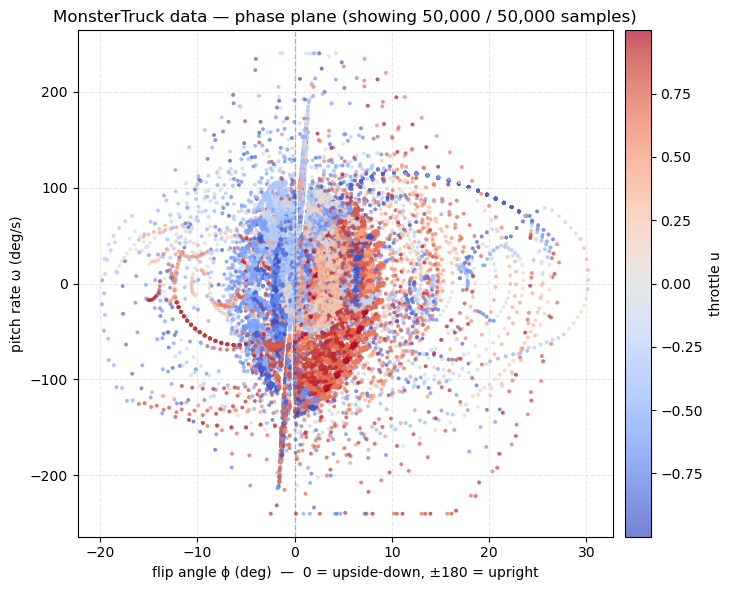

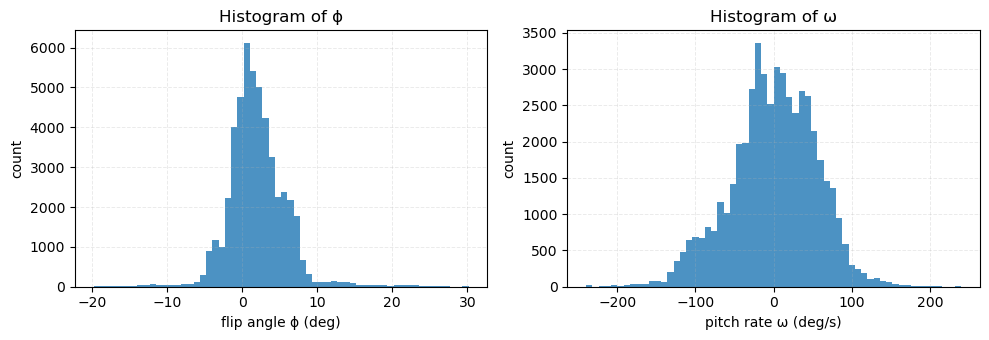

In [4]:
# =========================================================
# Cell 4 — Phase-plane visualization of collected data
#   - Scatter: φ vs ω colored by throttle u
#   - Histograms: φ and ω coverage
# =========================================================
import numpy as np
import matplotlib.pyplot as plt

# ---------- Load data (from memory or from file) ----------
if 'phi_arr' in globals() and 'omega_arr' in globals() and 'u_arr' in globals():
    phi = phi_arr
    omega = omega_arr
    u = u_arr
    print("[Cell 4] Using phi_arr/omega_arr/u_arr from memory.")
else:
    data = np.load("monstertruck_gp_initial_data.npz")
    phi = data["phi"]      # radians
    omega = data["omega"]  # radians/s (clipped)
    u = data["u"]
    print("[Cell 4] Loaded data from 'monstertruck_gp_initial_data.npz'.")

N = phi.shape[0]
phi_deg   = np.rad2deg(phi)
omega_deg = np.rad2deg(omega)

print(f"[Cell 4] N samples = {N}")
print(f"[Cell 4] φ range (deg) ≈ [{phi_deg.min():+.1f}, {phi_deg.max():+.1f}]")
print(f"[Cell 4] ω range (deg/s) ≈ [{omega_deg.min():+.1f}, {omega_deg.max():+.1f}]")
print(f"[Cell 4] u range        ≈ [{u.min():+.3f}, {u.max():+.3f}]")


# ---------- Scatter: phase plane with action color ----------
MAX_POINTS = 50_000
rng_vis = np.random.default_rng(0)
if N > MAX_POINTS:
    idx = rng_vis.choice(N, size=MAX_POINTS, replace=False)
    N_show = MAX_POINTS
else:
    idx = slice(None)
    N_show = N

fig, ax = plt.subplots(figsize=(7.5, 6))
sc = ax.scatter(
    phi_deg[idx],
    omega_deg[idx],
    c=u[idx],
    s=8,
    cmap="coolwarm",
    alpha=0.7,
    edgecolors="none",
)

ax.set_xlabel("flip angle ϕ (deg)  —  0 = upside-down, ±180 = upright")
ax.set_ylabel("pitch rate ω (deg/s)")
ax.set_title(f"MonsterTruck data — phase plane (showing {N_show:,} / {N:,} samples)")

# vertical line at upside-down and (optionally) upright bands
ax.axvline(0.0, color="k", linestyle="--", alpha=0.25, linewidth=1.0)
ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.8)

cb = fig.colorbar(sc, ax=ax, pad=0.02)
cb.set_label("throttle u")

plt.tight_layout()
plt.show()


# ---------- Histograms: φ and ω marginal distributions ----------
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(phi_deg, bins=60, alpha=0.8)
axes[0].set_xlabel("flip angle ϕ (deg)")
axes[0].set_ylabel("count")
axes[0].set_title("Histogram of ϕ")

axes[1].hist(omega_deg, bins=60, alpha=0.8)
axes[1].set_xlabel("pitch rate ω (deg/s)")
axes[1].set_ylabel("count")
axes[1].set_title("Histogram of ω")

for ax in axes:
    ax.grid(True, alpha=0.25, linestyle="--", linewidth=0.7)

plt.tight_layout()
plt.show()


Data Prep for GP Training

In [5]:
# =========================================================
# Cell 5 — GP data preparation (MonsterTruck dynamics)
#   - Use collected dataset X, Y
#   - Standardize X and Y
#   - Train/validation split
#   - Create PyTorch tensors (ready for GP training)
# =========================================================

import torch

# ---------- Load data ----------
# Prefer in-memory X, Y from collection cell; fall back to .npz
if 'X' in globals() and 'Y' in globals():
    X_np = X.astype(np.float32)
    Y_np = Y.astype(np.float32)
    print("[Cell 5] Using X, Y from memory.")
else:
    data = np.load("monstertruck_gp_initial_data.npz")
    X_np = data["X"].astype(np.float32)  # (N, 3): [phi, omega_clipped, u]
    Y_np = data["Y"].astype(np.float32)  # (N, 2): [dphi, domega]
    print("[Cell 5] Loaded 'monstertruck_gp_initial_data.npz'.")

N, Dx = X_np.shape
_, Dy = Y_np.shape
assert Dx == 3 and Dy == 2, f"Expected X:(N,3), Y:(N,2), got {X_np.shape}, {Y_np.shape}"

print(f"[Cell 5] N samples      = {N}")
print(f"[Cell 5] Input dim (Dx) = {Dx}  (phi, omega, u)")
print(f"[Cell 5] Output dim(Dy) = {Dy}  (dphi, domega)")

# Human-readable ranges (just info)
phi_deg   = np.rad2deg(X_np[:, 0])
omega_deg = np.rad2deg(X_np[:, 1])
print(f"[Cell 5] φ range (deg)         ≈ [{phi_deg.min():+.2f}, {phi_deg.max():+.2f}]")
print(f"[Cell 5] ω range (deg/s)       ≈ [{omega_deg.min():+.2f}, {omega_deg.max():+.2f}]")
print(f"[Cell 5] u range               ≈ [{X_np[:,2].min():+.3f}, {X_np[:,2].max():+.3f}]")
print(f"[Cell 5] dφ range (rad/step)   ≈ [{Y_np[:,0].min():+.3e}, {Y_np[:,0].max():+.3e}]")
print(f"[Cell 5] dω range (rad/s/step) ≈ [{Y_np[:,1].min():+.3e}, {Y_np[:,1].max():+.3e}]")


# ---------- Train/validation split ----------
rng_split    = np.random.default_rng(0)
perm         = rng_split.permutation(N)
train_frac   = 0.9
N_train      = int(train_frac * N)
train_idx    = perm[:N_train]
val_idx      = perm[N_train:]

X_train_np   = X_np[train_idx]
Y_train_np   = Y_np[train_idx]
X_val_np     = X_np[val_idx]
Y_val_np     = Y_np[val_idx]

print(f"[Cell 5] Train size = {X_train_np.shape[0]}, Val size = {X_val_np.shape[0]}")


# ---------- Standardization ----------
# Use train stats only
X_mean = X_train_np.mean(axis=0, keepdims=True)    # (1, 3)
X_std  = X_train_np.std(axis=0, keepdims=True) + 1e-6
Y_mean = Y_train_np.mean(axis=0, keepdims=True)    # (1, 2)
Y_std  = Y_train_np.std(axis=0, keepdims=True) + 1e-6

X_train_z = (X_train_np - X_mean) / X_std
Y_train_z = (Y_train_np - Y_mean) / Y_std
X_val_z   = (X_val_np   - X_mean) / X_std
Y_val_z   = (Y_val_np   - Y_mean) / Y_std

print("[Cell 5] Standardization stats:")
print(f"  X_mean = {X_mean.ravel()}")
print(f"  X_std  = {X_std.ravel()}")
print(f"  Y_mean = {Y_mean.ravel()}")
print(f"  Y_std  = {Y_std.ravel()}")


# ---------- Convert to PyTorch tensors ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Cell 5] Using device: {device}")

X_train_t = torch.from_numpy(X_train_z).to(device)
Y_train_t = torch.from_numpy(Y_train_z).to(device)
X_val_t   = torch.from_numpy(X_val_z).to(device)
Y_val_t   = torch.from_numpy(Y_val_z).to(device)

print(f"[Cell 5] X_train_t shape: {X_train_t.shape}")
print(f"[Cell 5] Y_train_t shape: {Y_train_t.shape}")
print(f"[Cell 5] X_val_t   shape: {X_val_t.shape}")
print(f"[Cell 5] Y_val_t   shape: {Y_val_t.shape}")


# ---------- Bundle metadata for GP + MPPI ----------
gp_data_meta = {
    "X_mean": torch.from_numpy(X_mean.astype(np.float32)).to(device),  # (1,3)
    "X_std":  torch.from_numpy(X_std.astype(np.float32)).to(device),
    "Y_mean": torch.from_numpy(Y_mean.astype(np.float32)).to(device),  # (1,2)
    "Y_std":  torch.from_numpy(Y_std.astype(np.float32)).to(device),
    "dt_ctrl": float(globals().get("dt_ctrl", 0.0)),  # from collection cell
}
print("[Cell 5] Saved normalization and dt_ctrl into gp_data_meta.")


[Cell 5] Using X, Y from memory.
[Cell 5] N samples      = 50000
[Cell 5] Input dim (Dx) = 3  (phi, omega, u)
[Cell 5] Output dim(Dy) = 2  (dphi, domega)
[Cell 5] φ range (deg)         ≈ [-19.81, +30.18]
[Cell 5] ω range (deg/s)       ≈ [-240.00, +240.00]
[Cell 5] u range               ≈ [-1.000, +1.000]
[Cell 5] dφ range (rad/step)   ≈ [-5.727e-02, +4.997e-02]
[Cell 5] dω range (rad/s/step) ≈ [-3.317e+00, +3.572e+00]
[Cell 5] Train size = 45000, Val size = 5000
[Cell 5] Standardization stats:
  X_mean = [0.0347027  0.001978   0.00026775]
  X_std  = [0.06950962 0.9568358  0.581091  ]
  Y_mean = [ 7.5844955e-06 -9.9872204e-04]
  Y_std  = [0.00961087 0.5298194 ]
[Cell 5] Using device: cuda
[Cell 5] X_train_t shape: torch.Size([45000, 3])
[Cell 5] Y_train_t shape: torch.Size([45000, 2])
[Cell 5] X_val_t   shape: torch.Size([5000, 3])
[Cell 5] Y_val_t   shape: torch.Size([5000, 2])
[Cell 5] Saved normalization and dt_ctrl into gp_data_meta.


In [6]:
# =========================================================
# Cell 5b — Two 1D SVGP dynamics models for MonsterTruck
#   - dyn_phi   : GP for Δφ
#   - dyn_omega : GP for Δω
#   - each is a simple SVGP with RBF kernel
# =========================================================

import torch
import gpytorch

assert 'X_train_t' in globals() and 'Y_train_t' in globals(), "[Cell 5b] Need X_train_t, Y_train_t from Cell 5."
assert 'device'   in globals(), "[Cell 5b] Need 'device' from Cell 5."

Xz = X_train_t         # (N,3)
Yz = Y_train_t         # (N,2)

N_train = Xz.size(0)
Dx      = Xz.size(1)
assert Dx == 3, f"[Cell 5b] Expected X dim 3, got {Dx}."

print(f"[Cell 5b] Using Xz={Xz.shape}, Yz={Yz.shape} for dynamics GPs.")

# ---------- Simple 1D SVGP model ----------

class MT_DynSVGP1D(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # inducing_points: (M, Dx)
        M, Dx = inducing_points.shape
        q = gpytorch.variational.CholeskyVariationalDistribution(M)
        vs = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            q,
            learn_inducing_locations=True,
        )
        super().__init__(vs)

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=Dx)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# ---------- Inducing points (shared for both tasks) ----------

M = min(256, N_train)
with torch.no_grad():
    # pick M evenly spaced training points as inducing locations
    idx = torch.linspace(0, N_train - 1, M).long()
    inducing_points = Xz[idx].clone()   # (M, 3)

# ---------- Two separate GPs: Δφ and Δω ----------

dyn_phi   = MT_DynSVGP1D(inducing_points).to(device)
dyn_omega = MT_DynSVGP1D(inducing_points).to(device)

lik_phi   = gpytorch.likelihoods.GaussianLikelihood().to(device)
lik_omega = gpytorch.likelihoods.GaussianLikelihood().to(device)

print("[Cell 5b] Created dyn_phi, dyn_omega and their GaussianLikelihoods.")
print(dyn_phi)


[Cell 5b] Using Xz=torch.Size([45000, 3]), Yz=torch.Size([45000, 2]) for dynamics GPs.
[Cell 5b] Created dyn_phi, dyn_omega and their GaussianLikelihoods.
MT_DynSVGP1D(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): CholeskyVariationalDistribution()
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)


GP Training Script

[Cell 6] Training on Xz=torch.Size([45000, 3]), Yz=torch.Size([45000, 2])


NELBO 1.238319 | lsφ~1.5533, lsω~0.3922 | noiseφ~0.1180, noiseω~0.2879: 100%|██████████| 800/800 [01:00<00:00, 13.29it/s]


[Cell 6] Training finished. Models & likelihoods set to eval().


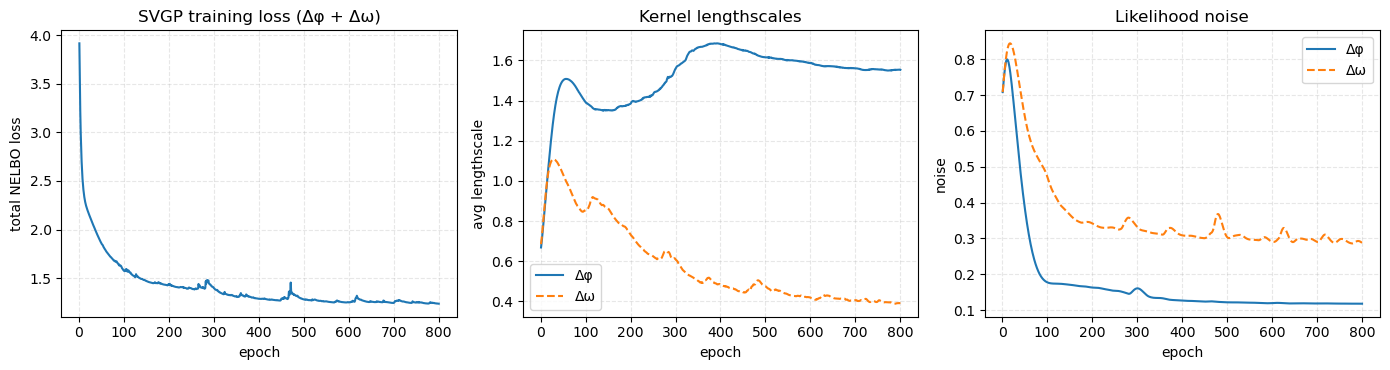

In [7]:
# =========================================================
# Cell 6 — Train Δφ & Δω SVGPs with ELBO + visualize training
# =========================================================

import torch, gpytorch, tqdm
import matplotlib.pyplot as plt
import numpy as np

# ---- sanity: need models and data from Cell 5 & 5b ----
assert 'dyn_phi'   in globals() and 'dyn_omega' in globals(), "[Cell 6] Need dyn_phi & dyn_omega from Cell 5b."
assert 'lik_phi'   in globals() and 'lik_omega' in globals(), "[Cell 6] Need lik_phi & lik_omega from Cell 5b."
assert 'X_train_t' in globals() and 'Y_train_t' in globals(),  "[Cell 6] Need X_train_t, Y_train_t from Cell 5."

Xz = X_train_t    # (N,3) standardized [phi, omega, u]
Yz = Y_train_t    # (N,2) standardized [dphi, domega]

print(f"[Cell 6] Training on Xz={Xz.shape}, Yz={Yz.shape}")

# Targets for each 1D GP
Y_phi   = Yz[:, 0].view(-1)   # Δφ
Y_omega = Yz[:, 1].view(-1)   # Δω

# Put everything in train mode
dyn_phi.train()
dyn_omega.train()
lik_phi.train()
lik_omega.train()

# Single optimizer over both GPs + both likelihoods
opt = torch.optim.Adam([
    {'params': dyn_phi.parameters(),   'lr': 0.05},
    {'params': lik_phi.parameters(),   'lr': 0.03},
    {'params': dyn_omega.parameters(), 'lr': 0.05},
    {'params': lik_omega.parameters(), 'lr': 0.03},
])

mll_phi   = gpytorch.mlls.VariationalELBO(lik_phi,   dyn_phi,   num_data=Y_phi.size(0))
mll_omega = gpytorch.mlls.VariationalELBO(lik_omega, dyn_omega, num_data=Y_omega.size(0))

E = 800  # epochs

loss_history        = []
ls_phi_history      = []
ls_omega_history    = []
noise_phi_history   = []
noise_omega_history = []

pbar = tqdm.tqdm(range(E))
for e in pbar:
    opt.zero_grad()

    # Forward both GPs
    out_phi   = dyn_phi(Xz)
    out_omega = dyn_omega(Xz)

    # Total loss = sum of two negative ELBOs
    loss = -mll_phi(out_phi, Y_phi) - mll_omega(out_omega, Y_omega)
    loss.backward()
    opt.step()

    loss_history.append(loss.item())

    # Log hyperparameters
    with torch.no_grad():
        # lengthscales (ARD -> average across dims)
        try:
            ls_phi = dyn_phi.covar_module.base_kernel.lengthscale.detach().view(-1).mean().item()
        except Exception:
            ls_phi = float('nan')
        try:
            ls_omega = dyn_omega.covar_module.base_kernel.lengthscale.detach().view(-1).mean().item()
        except Exception:
            ls_omega = float('nan')

        # noise params
        noise_phi  = lik_phi.noise.detach().item()
        noise_omega = lik_omega.noise.detach().item()

        ls_phi_history.append(ls_phi)
        ls_omega_history.append(ls_omega)
        noise_phi_history.append(noise_phi)
        noise_omega_history.append(noise_omega)

    if (e + 1) % 10 == 0 or e == 0:
        pbar.set_description(
            f"NELBO {loss.item():.6f} | "
            f"lsφ~{ls_phi:.4f}, lsω~{ls_omega:.4f} | "
            f"noiseφ~{noise_phi:.4f}, noiseω~{noise_omega:.4f}"
        )

# Put in eval mode for prediction
dyn_phi.eval()
dyn_omega.eval()
lik_phi.eval()
lik_omega.eval()
print("[Cell 6] Training finished. Models & likelihoods set to eval().")

# =========================================================
# Visualize training: loss, lengthscales, noise
# =========================================================

epochs = np.arange(1, E + 1)

fig, axes = plt.subplots(1, 3, figsize=(14, 3.8))

# 1) Total NELBO
axes[0].plot(epochs, loss_history, linewidth=1.5)
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("total NELBO loss")
axes[0].set_title("SVGP training loss (Δφ + Δω)")
axes[0].grid(True, alpha=0.3, linestyle="--")

# 2) Lengthscales
axes[1].plot(epochs, ls_phi_history,   label="Δφ",   linewidth=1.5)
axes[1].plot(epochs, ls_omega_history, label="Δω",   linewidth=1.5, linestyle="--")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("avg lengthscale")
axes[1].set_title("Kernel lengthscales")
axes[1].legend()
axes[1].grid(True, alpha=0.3, linestyle="--")

# 3) Noise
axes[2].plot(epochs, noise_phi_history,   label="Δφ", linewidth=1.5)
axes[2].plot(epochs, noise_omega_history, label="Δω", linewidth=1.5, linestyle="--")
axes[2].set_xlabel("epoch")
axes[2].set_ylabel("noise")
axes[2].set_title("Likelihood noise")
axes[2].legend()
axes[2].grid(True, alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()


Prep for MPPI Control

In [23]:
# =========================================================
# Cell 7 — GP dynamics helper (MonsterTruck, radians)
#   - Uses dyn_phi / dyn_omega + lik_phi / lik_omega
#   - Interface: (phi, omega, u) in NumPy → Δφ, Δω (+ variances)
#   - Supports split_var=True for MPPI explore cost
# =========================================================

import numpy as np
import torch

# Put GPs into eval mode
dyn_phi.eval()
dyn_omega.eval()
lik_phi.eval()
lik_omega.eval()

# Normalisation stats from Cell 5
X_mean = gp_data_meta["X_mean"].to(device)  # (1,3)
X_std  = gp_data_meta["X_std"].to(device)   # (1,3)
Y_mean = gp_data_meta["Y_mean"].to(device)  # (1,2)
Y_std  = gp_data_meta["Y_std"].to(device)   # (1,2)

# Convenience scalars for each output
Y_mean_phi   = Y_mean[0, 0]
Y_mean_omega = Y_mean[0, 1]
Y_std_phi    = Y_std[0, 0]
Y_std_omega  = Y_std[0, 1]


@torch.no_grad()
def gp_predict_delta_numpy(phi_rad, omega_rad_s, u,
                           return_variance=True,
                           split_var=False):
    """
    GP dynamics prediction in NumPy:

      Inputs:
        phi_rad      : array-like, shape (N,)  signed flip angle φ [rad]
        omega_rad_s  : array-like, shape (N,)  pitch rate ω [rad/s]
        u            : array-like, shape (N,) or scalar, throttle in [-1, 1]

      Returns:
        dphi_mean    : np.ndarray, shape (N,)
        domega_mean  : np.ndarray, shape (N,)

        If return_variance=True:
          - if split_var=False:
                total_var : np.ndarray, shape (N,)  (Var[Δφ] + Var[Δω])
          - if split_var=True:
                var_dp, var_dv : np.ndarray, shape (N,) each
    """
    # ---- pack inputs into X = [phi, omega, u] ----
    phi_arr   = np.atleast_1d(phi_rad).astype(np.float32)
    omega_arr = np.atleast_1d(omega_rad_s).astype(np.float32)

    if np.isscalar(u):
        u_arr = np.full_like(phi_arr, float(u), dtype=np.float32)
    else:
        u_arr = np.atleast_1d(u).astype(np.float32)

    assert phi_arr.shape == omega_arr.shape == u_arr.shape, \
        "[Cell 7] phi, omega, u must have same shape."

    X_np = np.stack([phi_arr, omega_arr, u_arr], axis=1)  # (N,3)

    # ---- standardize + send to device ----
    X_t = torch.from_numpy(X_np).to(device)
    Xz  = (X_t - X_mean) / X_std

    # ---- GP forward: Δφ ----
    f_phi   = lik_phi(dyn_phi(Xz))
    mean_z_phi = f_phi.mean        # (N,)
    var_z_phi  = f_phi.variance    # (N,)

    mean_phi_real = mean_z_phi * Y_std_phi + Y_mean_phi
    var_phi_real  = var_z_phi * (Y_std_phi ** 2)

    # ---- GP forward: Δω ----
    f_omega   = lik_omega(dyn_omega(Xz))
    mean_z_omega = f_omega.mean
    var_z_omega  = f_omega.variance

    mean_omega_real = mean_z_omega * Y_std_omega + Y_mean_omega
    var_omega_real  = var_z_omega * (Y_std_omega ** 2)

    # ---- back to NumPy ----
    dphi_mean   = mean_phi_real.cpu().numpy()
    domega_mean = mean_omega_real.cpu().numpy()

    if not return_variance:
        return dphi_mean, domega_mean

    var_dp = var_phi_real.cpu().numpy()
    var_dv = var_omega_real.cpu().numpy()

    if split_var:
        return dphi_mean, domega_mean, var_dp, var_dv

    total_var = var_dp + var_dv
    return dphi_mean, domega_mean, total_var


def gp_step_state_numpy(phi_rad, omega_rad_s, u,
                        return_variance=False):
    """
    One-step state update using GP:
      (φ, ω) → (φ_next, ω_next) over one control interval.
    Uses Δφ, Δω predicted by gp_predict_delta_numpy.
    """
    if return_variance:
        dphi, domega, var_dp, var_dv = gp_predict_delta_numpy(
            phi_rad, omega_rad_s, u,
            return_variance=True, split_var=True
        )
        var_tot = var_dp + var_dv
    else:
        dphi, domega = gp_predict_delta_numpy(
            phi_rad, omega_rad_s, u,
            return_variance=False
        )
        var_tot = None

    phi_next   = np.atleast_1d(phi_rad).astype(np.float32)   + dphi
    omega_next = np.atleast_1d(omega_rad_s).astype(np.float32) + domega

    if return_variance:
        return phi_next, omega_next, var_tot
    else:
        return phi_next, omega_next




In [24]:
# =========================================================
# Cell 7+8 — Cost functions + MPPI controller (MonsterTruck, radians)
#   - Assumes gp_predict_delta_numpy(...) is defined in the previous cell
#   - Uses GP for dynamics; no globals() name guessing
#   - Modes:
#       * "task"    : flip with shaped cost
#       * "explore" : pure variance-seeking in (Δφ, Δω)
# =========================================================

import numpy as np

# =========================================================
# 1) COST FUNCTIONS (TASK + EXPLORE)
# =========================================================

def build_monstertruck_cost_task(
    R=None,
    goal_sign=+1,              # unused, kept for compatibility
    success_enter_rad=None,
    success_release_rad=None,  # unused here
    max_upright_rate_rad=None,
    hold_needed=None,
):
    """
    Task cost: encourage flipping to upright (±π) with momentum shaping.
    Returns:
      step_cost(phi, omega, u, u_prev)
      terminal_bonus(phi_seq, omega_seq)
      R_used, success_enter_rad_used, max_upright_rate_rad_used, hold_used
    """
    R_defaults = {
        "position": 1.5,
        "tanh_gain": 1.5,
        "momentum": 0.75,
        "mom_gain": 1.0,
        "mom_power": 1.0,
        "energy": 0.05,
        "time": 1.0,
        "jerk": 0.3,
        "steady_bonus": 0.0,
        "steady_phi_tol": np.deg2rad(2.0),
        "steady_omega_tol": np.deg2rad(3.0),
        "success": 2000.0,
    }
    if R is not None:
        R_defaults.update(R)
    R_used = R_defaults

    # Local defaults (no globals)
    if success_enter_rad is None:
        success_enter_rad = np.deg2rad(178.0)
    if max_upright_rate_rad is None:
        max_upright_rate_rad = np.deg2rad(60.0)
    if hold_needed is None:
        hold_needed = 4

    def _wrap_to_pi(x):
        return (x + np.pi) % (2.0 * np.pi) - np.pi

    def _dist_near_upright(phi):
        d1 = np.abs(_wrap_to_pi(phi - np.pi))
        d2 = np.abs(_wrap_to_pi(phi + np.pi))
        return np.minimum(d1, d2)

    def step_cost(phi, omega, u, u_prev):
        phi    = np.asarray(phi,    float)
        omega  = np.asarray(omega,  float)
        u      = np.asarray(u,      float)
        u_prev = np.asarray(u_prev, float)

        # Position shaping toward +π
        d_fwd   = (np.pi - phi) / np.pi
        d_clip2 = np.clip(d_fwd, 0.0, 2.0)
        pos_pen = R_used["position"] * (np.tanh(R_used["tanh_gain"] * (2.0 * d_clip2)) ** 2)

        # Momentum encouragement (negative cost)
        d_near    = _dist_near_upright(phi) / np.pi
        mom_gate  = d_near ** R_used["mom_power"]
        mom_reward = R_used["momentum"] * np.tanh(R_used["mom_gain"] * np.abs(omega)) * mom_gate
        mom_term   = -mom_reward

        energy_pen = R_used["energy"] * (u ** 2)
        time_pen   = R_used["time"]
        jerk_pen   = R_used["jerk"] * np.abs(u - u_prev)

        # Optional steady bonus (usually off)
        steady = 0.0
        if R_used["steady_bonus"] > 0.0:
            close_angle = (np.abs(_wrap_to_pi(phi - np.pi)) <= R_used["steady_phi_tol"])
            slow_rate   = (np.abs(omega) <= R_used["steady_omega_tol"])
            steady = -R_used["steady_bonus"] * (close_angle & slow_rate).astype(float)

        return pos_pen + mom_term + energy_pen + time_pen + jerk_pen + steady

    def terminal_bonus(phi_seq, omega_seq):
        """
        Sequence-based bonus: large negative cost when we manage
        to hold upright for hold_needed steps.
        """
        phi_seq   = np.asarray(phi_seq,   float)
        omega_seq = np.asarray(omega_seq, float)

        def _ok(phi, omg):
            return (np.abs(phi) >= success_enter_rad) & (np.abs(omg) <= max_upright_rate_rad)

        if phi_seq.ndim == 1:
            run = 0
            for t in range(phi_seq.shape[0]):
                if _ok(phi_seq[t], omega_seq[t]):
                    run += 1
                    if run >= hold_needed:
                        return -R_used["success"]
                else:
                    run = 0
            return 0.0
        elif phi_seq.ndim == 2:
            T, B = phi_seq.shape
            bonus = np.zeros(B, float)
            run   = np.zeros(B, int)
            hit   = np.zeros(B, bool)
            for t in range(T):
                ok = _ok(phi_seq[t], omega_seq[t])
                run = np.where(ok, run + 1, 0)
                newly = (run >= hold_needed) & (~hit)
                bonus[newly] = -R_used["success"]
                hit |= newly
            return bonus
        else:
            raise ValueError("terminal_bonus expects shapes (T,) or (T,B)")

    return step_cost, terminal_bonus, R_used, success_enter_rad, max_upright_rate_rad, hold_needed


def build_monstertruck_cost_explore(
    beta_var=1.0,
    uncert_weights=(1.0, 1.0),
):
    """
    PURE variance-seeking exploration cost:

        cost = - beta_var * (w_dp * Var[Δϕ] + w_dv * Var[Δω])

    No energy, time, or jerk terms here.
    """
    BETA  = float(beta_var)
    W_DP, W_DV = float(uncert_weights[0]), float(uncert_weights[1])

    def step_cost_explore(phi, omega, u, u_prev, var_dp, var_dv):
        vdp = np.asarray(var_dp, float)
        vdv = np.asarray(var_dv, float)
        var_reward = BETA * (W_DP * vdp + W_DV * vdv)
        return -var_reward

    def terminal_zero(*args, **kwargs):
        if len(args) > 0 and isinstance(args[0], np.ndarray) and args[0].ndim == 2:
            B = args[0].shape[1]
            return np.zeros(B, float)
        return 0.0

    return step_cost_explore, terminal_zero


def make_state_cost_callbacks_task(
    R=None,
    goal_sign=+1,
    success_enter_rad=None,
    success_release_rad=None,
    max_upright_rate_rad=None,
    hold_needed=None,
):
    """
    Wrap task cost into state-based callbacks used by MPPI.
    """
    step_cost, _terminal_seq, R_used, se, omg_lim, hold = build_monstertruck_cost_task(
        R=R,
        goal_sign=goal_sign,
        success_enter_rad=success_enter_rad,
        success_release_rad=success_release_rad,
        max_upright_rate_rad=max_upright_rate_rad,
        hold_needed=hold_needed,
    )

    def step_cost_cb(states, actions, u_prev):
        S = np.asarray(states,  float)         # (K, 2)
        U = np.asarray(actions, float).reshape(-1)
        if u_prev is None:
            Uprev = np.zeros_like(U)
        else:
            Uprev = np.asarray(u_prev, float).reshape(-1)
        return step_cost(S[:, 0], S[:, 1], U, Uprev)

    def terminal_cost_final_cb(phi_final, omega_final):
        phi_final   = np.asarray(phi_final,   float).reshape(-1)
        omega_final = np.asarray(omega_final, float).reshape(-1)
        ok = (np.abs(phi_final) >= se) & (np.abs(omega_final) <= omg_lim)
        bonus = np.zeros_like(phi_final, float)
        bonus[ok] = -R_used["success"]
        return bonus

    return step_cost_cb, terminal_cost_final_cb


def make_state_cost_callbacks_explore(
    beta_var=1.0,
    uncert_weights=(1.0, 1.0),
):
    """
    Wrap pure variance cost into MPPI callbacks.
    """
    step_cost_explore, terminal_zero = build_monstertruck_cost_explore(
        beta_var=beta_var,
        uncert_weights=uncert_weights,
    )

    def step_cost_cb(states, actions, u_prev, *, var_dp, var_dv):
        S = np.asarray(states,  float)   # we only use S[:,0], S[:,1] for signature
        U = np.asarray(actions, float).reshape(-1)
        return step_cost_explore(S[:, 0], S[:, 1], U, u_prev,
                                 var_dp=var_dp, var_dv=var_dv)

    def terminal_cost_final_cb(phi_final, omega_final):
        return terminal_zero(phi_final, omega_final)

    return step_cost_cb, terminal_cost_final_cb


# =========================================================
# 2) GP-MPPI controller (TASK / EXPLORE)
#   (uses gp_predict_delta_numpy from previous cell)
# =========================================================

class GP_MPPI_MT:
    def __init__(self,
                 mode="task",        # "task" or "explore"
                 horizon=40,
                 n_samples=512,
                 lambda_=1.0,
                 u_sigma=0.6,
                 action_low=-1.0,
                 action_high=1.0,
                 task_R=None,
                 explore_beta_var=1.0,
                 explore_uncert_weights=(1.0, 1.0),
                 # explicit thresholds (no globals, can be None -> defaults)
                 success_enter_rad=None,
                 success_release_rad=None,
                 max_upright_rate_rad=None,
                 hold_needed=None,
                 seed=0,
                 warm_start=True):
        self.mode = mode
        self.T    = int(horizon)
        self.K    = int(n_samples)
        self.lmb  = float(lambda_)
        self.u_sigma = float(u_sigma)
        self.action_low  = float(action_low)
        self.action_high = float(action_high)
        self.warm_start  = bool(warm_start)

        self.rng = np.random.default_rng(seed)
        self.u_mean = np.zeros(self.T, dtype=np.float32)

        if mode == "task":
            step_cb, term_cb = make_state_cost_callbacks_task(
                R=task_R,
                goal_sign=+1,
                success_enter_rad=success_enter_rad,
                success_release_rad=success_release_rad,
                max_upright_rate_rad=max_upright_rate_rad,
                hold_needed=hold_needed,
            )
        elif mode == "explore":
            step_cb, term_cb = make_state_cost_callbacks_explore(
                beta_var=explore_beta_var,
                uncert_weights=explore_uncert_weights,
            )
        else:
            raise ValueError("mode must be 'task' or 'explore'.")

        self.step_cost_cb = step_cb
        self.term_cost_cb = term_cb

    def plan(self, phi0, omega0):
        """
        One MPPI update from current state (phi0, omega0).
        Returns:
          u_star : scalar throttle
          info   : diagnostics (costs, weights, trajectories)
        """
        K, T = self.K, self.T

        if not self.warm_start:
            self.u_mean[:] = 0.0

        # Sample control sequences
        noise = self.rng.normal(0.0, self.u_sigma, size=(K, T))
        U = self.u_mean[None, :] + noise
        U = np.clip(U, self.action_low, self.action_high)

        # Initial state replicated across samples
        phi = np.full(K, float(phi0), dtype=np.float32)
        omg = np.full(K, float(omega0), dtype=np.float32)
        u_prev = np.zeros(K, dtype=np.float32)

        S = np.zeros(K, dtype=np.float32)

        for t in range(T):
            u_t = U[:, t]

            if self.mode == "explore":
                dphi, domega, var_dp, var_dv = gp_predict_delta_numpy(
                    phi, omg, u_t, return_variance=True, split_var=True
                )
            else:
                dphi, domega = gp_predict_delta_numpy(
                    phi, omg, u_t, return_variance=False
                )
                var_dp = var_dv = None

            phi = phi + dphi
            omg = omg + domega

            states = np.stack([phi, omg], axis=1)

            if self.mode == "explore":
                step_c = self.step_cost_cb(states, u_t, u_prev,
                                           var_dp=var_dp, var_dv=var_dv)
            else:
                step_c = self.step_cost_cb(states, u_t, u_prev)

            S += step_c.astype(np.float32)
            u_prev = u_t.astype(np.float32)

        # Terminal cost: scalar or per-sample
        term = self.term_cost_cb(phi, omg)
        term = np.asarray(term, dtype=np.float32)
        if term.shape == ():      # scalar → broadcast if needed
            term = np.zeros_like(S, dtype=np.float32)
        S += term

        # MPPI weighting
        S_min = S.min()
        w = np.exp(-(S - S_min) / self.lmb)
        w /= (w.sum() + 1e-12)

        # Update mean sequence and extract first control
        self.u_mean = np.sum(w[:, None] * U, axis=0).astype(np.float32)
        u_star = float(np.clip(self.u_mean[0], self.action_low, self.action_high))

        info = {
            "S": S,
            "weights": w,
            "U": U,
            "phi_final": phi,
            "omega_final": omg,
        }
        return u_star, info


MPPI Rollout + Retraining Loop

In [28]:
# =========================================================
# Cell 9 — MuJoCo rollout + curriculum explore + retrain
#   - Uses GP_MPPI_MT (task + explore) and gp_predict_delta_numpy
#   - Two-phase control per rollout:
#       1) TASK MPPI for first TASK_PREFIX_STEPS
#       2) EXPLORE MPPI beyond that point, starting around task u_mean
#   - Retrains dyn_phi / dyn_omega on a growing replay buffer
#   - Shows occupancy + loss in persistent GUI windows (Qt/Tk)
#   - Stops once we achieve stable upright success
# =========================================================

import os
import numpy as np
import torch
import gpytorch

# ---------- Matplotlib: force GUI backend (NO inline) ----------
import matplotlib
try:
    matplotlib.use("QtAgg")     # preferred if you have Qt
except Exception:
    try:
        matplotlib.use("TkAgg") # fallback
    except Exception:
        pass

import matplotlib.pyplot as plt
plt.ion()  # interactive mode: update existing windows, non-blocking

# Safe tqdm import
try:
    import tqdm
    _tqdm = tqdm.tqdm
except Exception:
    _tqdm = lambda x: x

# ------------------ High-level config ------------------

TASK_HORIZON       = 20       # MPPI task horizon
EXPLORE_HORIZON    = 20       # MPPI explore horizon
TASK_SAMPLES       = 512      # task MPPI samples
EXPLORE_SAMPLES    = 2000     # explore MPPI samples (big search)
TASK_U_SIGMA       = 0.7
EXPLORE_U_SIGMA    = 0.9

TASK_PREFIX_STEPS  = 20       # real steps with task controller first
MAX_CTRL_STEPS     = 1500     # control steps per rollout  <-- gives ~1500 new samples
N_ITER             = 6        # rollout + retrain cycles

RETRAIN_EPOCHS     = 120
LR_MODEL           = 0.04
LR_LIK             = 0.03

PHI_RANGE          = (-np.pi, np.pi)
OMEGA_RANGE        = (-8.0, 8.0)
BINS_PHI           = 40
BINS_OMEGA         = 40

print(f"[Cell 9] N_ITER={N_ITER}, MAX_CTRL_STEPS={MAX_CTRL_STEPS}")
print(f"         TASK: horizon={TASK_HORIZON}, K={TASK_SAMPLES}, u_sigma={TASK_U_SIGMA}")
print(f"         EXPLORE: horizon={EXPLORE_HORIZON}, K={EXPLORE_SAMPLES}, u_sigma={EXPLORE_U_SIGMA}")

# ------------------ Ensure MuJoCo + helpers exist ------------------

if 'model' not in globals() or 'data' not in globals():
    if 'XML_PATH' not in globals():
        raise RuntimeError("[Cell 9] Need XML_PATH defined for MuJoCo model.")
    if not os.path.exists(XML_PATH):
        raise FileNotFoundError(f"[Cell 9] Cannot find XML_PATH: {XML_PATH}")
    model = mujoco.MjModel.from_xml_path(XML_PATH)
    data  = mujoco.MjData(model)

# chassis id
if 'chassis_id' not in globals():
    cid = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
    chassis_id = cid if cid != -1 else 0

# actuators
if 'throttle_ids' not in globals():
    throttle_ids = find_throttle_ids(model)

# flip tracker
if 'flip_tracker' not in globals():
    flip_tracker = make_flip_tracker(model, frame_skip=FRAME_SKIP)

dt_ctrl = model.opt.timestep * FRAME_SKIP
print(f"[Cell 9] Using actuators: {[mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_ACTUATOR, i) for i in throttle_ids]}")
print(f"[Cell 9] FRAME_SKIP={FRAME_SKIP}, dt_ctrl={dt_ctrl:.4f} s")

# ------------------ Occupancy grid + persistent window ------------------

phi_edges   = np.linspace(PHI_RANGE[0], PHI_RANGE[1], BINS_PHI + 1)
omega_edges = np.linspace(OMEGA_RANGE[0], OMEGA_RANGE[1], BINS_OMEGA + 1)
occ_counts  = np.zeros((BINS_OMEGA, BINS_PHI), dtype=np.int32)  # [ω, φ]

_occ_fig  = None
_occ_ax   = None
_occ_img  = None

def update_occ_counts(occ, phi_arr, omega_arr):
    if phi_arr.size == 0:
        return
    phi_idx = np.clip(np.digitize(phi_arr, phi_edges)   - 1, 0, BINS_PHI   - 1)
    omg_idx = np.clip(np.digitize(omega_arr, omega_edges) - 1, 0, BINS_OMEGA - 1)
    for i in range(phi_idx.size):
        occ[omg_idx[i], phi_idx[i]] += 1

def init_occ_plot():
    global _occ_fig, _occ_ax, _occ_img
    if _occ_fig is not None:
        return _occ_fig, _occ_ax, _occ_img

    _occ_fig, _occ_ax = plt.subplots(figsize=(5.5, 4.5))
    extent = [phi_edges[0], phi_edges[-1], omega_edges[0], omega_edges[-1]]
    _occ_img = _occ_ax.imshow(
        occ_counts,
        origin="lower",
        extent=extent,
        aspect="auto",
        interpolation="nearest"
    )
    _occ_fig.colorbar(_occ_img, ax=_occ_ax, label="count")
    _occ_ax.set_xlabel("signed flip angle ϕ (rad)")
    _occ_ax.set_ylabel("pitch-rate ω (rad/s)")
    se = globals().get("SUCCESS_ENTER_RAD", np.deg2rad(178.0))
    _occ_ax.axvline(se,  color="y", linestyle="--", alpha=0.7)
    _occ_ax.axvline(-se, color="y", linestyle="--", alpha=0.7)
    _occ_fig.tight_layout()
    _occ_fig.show()
    _occ_fig.canvas.draw()
    return _occ_fig, _occ_ax, _occ_img

def update_occ_plot(title="Bin occupancy over (φ, ω)"):
    global _occ_fig, _occ_ax, _occ_img
    if _occ_fig is None:
        init_occ_plot()

    filled = np.count_nonzero(occ_counts > 0)
    total  = occ_counts.size

    _occ_img.set_data(occ_counts)
    vmax = occ_counts.max()
    if vmax <= 0:
        vmax = 1
    _occ_img.set_clim(vmin=0, vmax=vmax)
    _occ_ax.set_title(f"{title}\nfilled bins = {filled}/{total} ({filled/total*100:.1f}%)")
    _occ_fig.canvas.draw()
    _occ_fig.canvas.flush_events()

# ------------------ Loss window (persistent) ------------------

_loss_fig = None
_loss_ax  = None

def init_loss_plot():
    global _loss_fig, _loss_ax
    if _loss_fig is not None:
        return _loss_fig, _loss_ax
    _loss_fig, _loss_ax = plt.subplots(figsize=(4, 3))
    _loss_fig.tight_layout()
    _loss_fig.show()
    _loss_fig.canvas.draw()
    return _loss_fig, _loss_ax

def update_loss_plot(losses, iter_idx=None):
    global _loss_fig, _loss_ax
    if _loss_fig is None:
        init_loss_plot()

    _loss_ax.clear()
    _loss_ax.plot(losses)
    _loss_ax.set_xlabel("epoch")
    _loss_ax.set_ylabel("NELBO")
    if iter_idx is not None:
        _loss_ax.set_title(f"SVGP retrain loss (Iter {iter_idx})")
    else:
        _loss_ax.set_title("SVGP retrain loss")
    _loss_ax.grid(True, alpha=0.3, linestyle="--")
    _loss_fig.tight_layout()
    _loss_fig.canvas.draw()
    _loss_fig.canvas.flush_events()

# ------------------ Seed occupancy with initial training data ------------------

if 'X_train_np' in globals():
    phi_init = X_train_np[:, 0].astype(np.float32)
    omg_init = X_train_np[:, 1].astype(np.float32)
    update_occ_counts(occ_counts, phi_init, omg_init)
    init_occ_plot()
    update_occ_plot(title="[Iter 0] Initial data occupancy")
else:
    print("[Cell 9] WARNING: X_train_np not found; starting bins empty.")

# ------------------ Replay dataset bootstrap ------------------

if 'X_train_np' not in globals() or 'Y_train_np' not in globals():
    raise RuntimeError("[Cell 9] Need X_train_np and Y_train_np from GP data prep (Cell 5).")

X_replay = torch.from_numpy(X_train_np.astype(np.float32)).to(device)  # (N,3)
Y_replay = torch.from_numpy(Y_train_np.astype(np.float32)).to(device)  # (N,2)

print(f"[Cell 9] Starting replay dataset: {X_replay.shape[0]} samples.")

# ------------------ Retrain dyn_phi & dyn_omega on replay ------------------

def retrain_svgps_on_replay(X_replay, Y_replay, epochs=100,
                            lr_model=0.04, lr_lik=0.03, verbose=True):
    dyn_phi.train()
    dyn_omega.train()
    lik_phi.train()
    lik_omega.train()

    X_mean = gp_data_meta["X_mean"].to(device)
    X_std  = gp_data_meta["X_std"].to(device)
    Y_mean = gp_data_meta["Y_mean"].to(device)
    Y_std  = gp_data_meta["Y_std"].to(device)

    Y_mean_phi   = Y_mean[0, 0]
    Y_mean_omega = Y_mean[0, 1]
    Y_std_phi    = Y_std[0, 0]
    Y_std_omega  = Y_std[0, 1]

    Xz        = (X_replay - X_mean) / X_std
    Y_phi_z   = (Y_replay[:, 0] - Y_mean_phi)   / Y_std_phi
    Y_omega_z = (Y_replay[:, 1] - Y_mean_omega) / Y_std_omega

    mll_phi   = gpytorch.mlls.VariationalELBO(lik_phi,   dyn_phi,   num_data=Y_phi_z.numel())
    mll_omega = gpytorch.mlls.VariationalELBO(lik_omega, dyn_omega, num_data=Y_omega_z.numel())

    opt = torch.optim.Adam([
        {'params': dyn_phi.parameters(),   'lr': lr_model},
        {'params': lik_phi.parameters(),   'lr': lr_lik},
        {'params': dyn_omega.parameters(), 'lr': lr_model},
        {'params': lik_omega.parameters(), 'lr': lr_lik},
    ])

    losses = []
    pbar = _tqdm(range(epochs))
    for e in pbar:
        opt.zero_grad()
        out_phi   = dyn_phi(Xz)
        out_omega = dyn_omega(Xz)
        loss = -mll_phi(out_phi, Y_phi_z) - mll_omega(out_omega, Y_omega_z)
        loss.backward()
        opt.step()
        losses.append(loss.item())

        if (e + 1) % 10 == 0 or e == 1:
            pbar.set_description(f"[Retrain] NELBO={loss.item():.4f}")

    dyn_phi.eval()
    dyn_omega.eval()
    lik_phi.eval()
    lik_omega.eval()

    if verbose:
        print(f"[Retrain] Finished {epochs} epochs. Final NELBO={losses[-1]:.6f}")
    return losses

# ------------------ Rollout: task prefix then explore ------------------

def run_mujoco_rollout_curriculum(task_mppi, explore_mppi,
                                  max_steps=80, prefix_task_steps=10):
    reset_state(model, data)
    flip_tracker.reset()
    mujoco.mj_forward(model, data)

    se   = globals().get("SUCCESS_ENTER_RAD",    np.deg2rad(178.0))
    maxw = globals().get("MAX_UPRIGHT_RATE_RAD", np.deg2rad(60.0))
    hold_needed = globals().get("HOLD_NEEDED",   4)

    X_list, Y_list = [], []
    phi_list, omg_list = [], []

    upright_run = 0
    success = False

    task_steps    = 0
    explore_steps = 0

    for t in range(max_steps):
        mujoco.mj_forward(model, data)
        phi, omega, _ = flip_tracker.step(data, chassis_id)

        # ----- choose controller -----
        if t < prefix_task_steps:
            u_star, _ = task_mppi.plan(phi0=phi, omega0=omega)
            task_steps += 1
        else:
            u_star, _ = explore_mppi.plan(phi0=phi, omega0=omega)
            explore_steps += 1

        phi_list.append(phi)
        omg_list.append(omega)

        phi_before = phi
        omg_before = omega

        apply_throttle(data, throttle_ids, u_star)
        for _ in range(FRAME_SKIP):
            mujoco.mj_step(model, data)

        mujoco.mj_forward(model, data)
        phi_after, omega_after, _ = flip_tracker.step(data, chassis_id)

        dphi   = angdiff_rad(phi_after, phi_before)
        domega = omega_after - omg_before

        X_list.append([phi_before, omg_before, u_star])
        Y_list.append([dphi, domega])

        if (abs(phi_after) >= se) and (abs(omega_after) <= maxw):
            upright_run += 1
        else:
            upright_run = 0

        if upright_run >= hold_needed:
            print(f"[Rollout] SUCCESS after t={t+1} steps (task={task_steps}, explore={explore_steps}).")
            success = True
            break

    X_new_np = np.asarray(X_list, float)
    Y_new_np = np.asarray(Y_list, float)
    phi_arr  = np.asarray(phi_list, float)
    omg_arr  = np.asarray(omg_list, float)

    print(f"[Rollout] Finished with total_steps={X_new_np.shape[0]}, "
          f"task_steps={task_steps}, explore_steps={explore_steps}")

    return X_new_np, Y_new_np, phi_arr, omg_arr, success

# ------------------ Main loop ------------------

init_occ_plot()
init_loss_plot()

global_success = False

for it in range(1, N_ITER + 1):
    print(f"\n========== Iteration {it}/{N_ITER} ==========")

    task_mppi = GP_MPPI_MT(
        mode="task",
        horizon=TASK_HORIZON,
        n_samples=TASK_SAMPLES,
        lambda_=1.0,
        u_sigma=TASK_U_SIGMA,
        action_low=ACTION_LOW,
        action_high=ACTION_HIGH,
        task_R=None,
        seed=1234 + it,
        warm_start=True,
    )

    explore_mppi = GP_MPPI_MT(
        mode="explore",
        horizon=EXPLORE_HORIZON,
        n_samples=EXPLORE_SAMPLES,
        lambda_=1.0,
        u_sigma=EXPLORE_U_SIGMA,
        action_low=ACTION_LOW,
        action_high=ACTION_HIGH,
        explore_beta_var=1.0,
        explore_uncert_weights=(1.0, 1.0),
        seed=5678 + it,
        warm_start=True,
    )

    X_new_np, Y_new_np, phi_roll, omg_roll, success = run_mujoco_rollout_curriculum(
        task_mppi,
        explore_mppi,
        max_steps=MAX_CTRL_STEPS,
        prefix_task_steps=TASK_PREFIX_STEPS,
    )
    print(f"[Iter {it}] Collected {X_new_np.shape[0]} new samples from rollout.")

    update_occ_counts(occ_counts, phi_roll, omg_roll)
    update_occ_plot(title=f"[Iter {it}] Occupancy after rollout")

    X_new = torch.from_numpy(X_new_np.astype(np.float32)).to(device)
    Y_new = torch.from_numpy(Y_new_np.astype(np.float32)).to(device)

    X_replay = torch.cat([X_replay, X_new], dim=0)
    Y_replay = torch.cat([Y_replay, Y_new], dim=0)
    print(f"[Iter {it}] Replay size now: {X_replay.shape[0]} samples.")

    losses = retrain_svgps_on_replay(
        X_replay, Y_replay,
        epochs=RETRAIN_EPOCHS,
        lr_model=LR_MODEL,
        lr_lik=LR_LIK,
        verbose=True,
    )
    update_loss_plot(losses, iter_idx=it)

    if success:
        print(f"[Cell 9] Stopping early: global success reached at iteration {it}.")
        global_success = True
        break

print("\n[Cell 9] Done: rollouts, retraining, and bin coverage updates.")
if global_success:
    print("[Cell 9] Final status: SUCCESS achieved 🎉")
else:
    print("[Cell 9] Final status: no stable success within N_ITER.")


[Cell 9] N_ITER=6, MAX_CTRL_STEPS=1500
         TASK: horizon=20, K=512, u_sigma=0.7
         EXPLORE: horizon=20, K=2000, u_sigma=0.9
[Cell 9] Using actuators: ['front_left_motor', 'front_right_motor', 'rear_left_motor', 'rear_right_motor']
[Cell 9] FRAME_SKIP=10, dt_ctrl=0.0100 s
[Cell 9] Starting replay dataset: 45000 samples.

========== Iteration 1/6 ==========


KeyboardInterrupt: 